<a href="https://colab.research.google.com/github/AkshitAggarwal/TSAI_EVA5B2_Phase1/blob/main/Session_05/S5_Assignment_Step1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Call all necessary libraries. 

 Only call libraries and dependencies which are used in the notebook, because each library takes up additional memory. 
  

In [16]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy 

### 2. Create data transform compose. 

Use the compose function from `torch.transforms` to compile all necessarry data transformations that you want to apply to your datasets in one place. 

In [17]:
train_transforms = transforms.Compose([
                                      # transforms.RandomRotation(degrees=(-7, 7), fill=(1,)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])
test_transforms = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                    ])

### 3. Create datasets. 

Create your `train`, `validate`, `test` datasets and apply the transforms that were created above using compose. 

In [18]:
train_dataset = datasets.MNIST(root='./data', train = True, transform = train_transforms, download = True)
test_dataset = datasets.MNIST(root='./data', train = False, transform = test_transforms, download = True)

### 4. Create dataloaders. 

Create dataloaders for respective datasets. Dataloaders are iterable objects that can be fed to the model in smaller, randomized batches to avoid overfitting. 

In [19]:
SEED = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu") #Assigns device based on availability

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

#Arguments to be fed into dataloaders. 
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

##Train and Test dataloaders. 
train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

### 5. Data statistics.

Check all necessary data statistics, such as min, max, std, mean values of the dataset. 

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


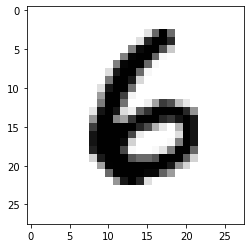

In [20]:
train_data = train_dataset.train_data
train_data = train_dataset.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train_dataset.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_dataset.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

### 6. Visualize dataset. 

Take a look at a few images of the training dataset. It gives you an idea of what you're dealing with. By looking at the dataset examples you can determine how difficult your task can be and what kind of transformations may help your model predict better. 

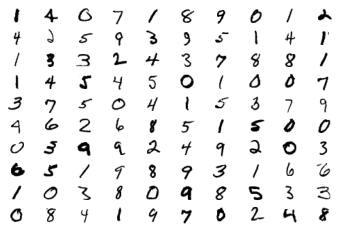

In [21]:
figure = plt.figure()
num_of_images = 100
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### 7. Define model architecture. 

Create your model class and define model architecture. Keep in mind things like 


1. Model complexity
2. Number of layers
3. Parameters
4. Padding in Conv Layers
5. Kernel size
6. Receptive field



In [35]:
class Net(nn.Module):
    #Constructor function initializes an object of Net() and defines all the layers. 
    #Each layer is defined here separately and aren't connected to each other in any way yet. 
    def __init__(self):
        super(Net, self).__init__()
        self.convBlock1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, bias = False), #in_channel: 1,28,28; out_channel: 16,26,26; RF: 3
            nn.ReLU(),
            # nn.BatchNorm2d(16),
            # nn.Dropout(0.1)
        )  
        self.convBlock2 = nn.Sequential(
            nn.Conv2d(16, 16, 3, bias = False), #in_channel: 16,26,26; out_channel: 16,24,24; RF: 5
            nn.ReLU(),
            # nn.BatchNorm2d(16),
            # nn.Dropout(0.1)
        )
        self.convBlock3 = nn.Sequential(
            nn.Conv2d(16, 32, 3, bias = False), #in_channel: 16,24,24; out_channel: 32,22,22; RF: 12
            nn.ReLU(),
            # nn.BatchNorm2d(32),
            # nn.Dropout(0.1)
        )
        self.pool1 = nn.MaxPool2d(2, 2) #in_channel: 32,22,22; out_channel: 32,11,11; RF: 10
        self.convBlock4 = nn.Sequential(
            nn.Conv2d(32, 32, 3, bias = False), #in_channel: 32,11,11; out_channel: 32,9,9; RF: 14
            nn.ReLU(),
            # nn.BatchNorm2d(32),
            # nn.Dropout(0.1)
        )
        self.convBlock5 = nn.Sequential(
            nn.Conv2d(32, 10, 3, bias = False), #in_channel: 32,9,9; out_channel: 10,7,7; RF: 30
            nn.ReLU(),
            # nn.BatchNorm2d(10),
            # nn.Dropout(0.1)
        )
        self.gap = nn.AvgPool2d((7, 7)) #in_channel: 10,7,7; out_channel: 10,1,1; RF: ?
        self.convBlock6 = nn.Sequential(
            nn.Conv2d(10, 20, 1, bias = False), #in_channel: 10,1,1; out_channel: 20,1,1; 
            nn.ReLU(),
            # nn.BatchNorm2d(20),
            # nn.Dropout(0.1)
        )
        self.convBlock7 = nn.Conv2d(20, 10, 1, bias = False) #in_channel: 20,1,1; out_channel: 10,1,1; 

    #Forward function takes an object and it passes through each layer sequentially. 
    def forward(self, x):
        x = self.convBlock1(x)
        x = self.convBlock2(x)
        x = self.convBlock3(x)
        x = self.pool1(x)
        x = self.convBlock4(x)
        x = self.convBlock5(x)
        x = self.gap(x)
        x = self.convBlock6(x)
        x = self.convBlock7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim = -1)

### 8. Look at model summary. 

Use `torchsummary` to look at model summary, load the model on gpu if available. 

In [36]:
!pip install torchsummary
from torchsummary import summary
model = Net().to(device) #Converts our model into the respective device.
summary(model, input_size=(1, 28, 28)) #Prints the summary of our model based on an input size.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           2,304
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 32, 22, 22]           4,608
              ReLU-6           [-1, 32, 22, 22]               0
         MaxPool2d-7           [-1, 32, 11, 11]               0
            Conv2d-8             [-1, 32, 9, 9]           9,216
              ReLU-9             [-1, 32, 9, 9]               0
           Conv2d-10             [-1, 10, 7, 7]           2,880
             ReLU-11             [-1, 10, 7, 7]               0
        AvgPool2d-12             [-1, 10, 1, 1]               0
           Conv2d-13             [-1, 20, 1, 1]             200
             ReLU-14             [-1, 2

### 9. Define Train and Test functions

In [37]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
train_samples = len(train_loader.dataset)
test_samples = len(test_loader.dataset)
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    total_correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device) #Loading the images and targets on the GPU
        optimizer.zero_grad() 
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        train_loss += loss #Calculating the total loss for the epoch. 
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        total_correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        train_accuracies.append(100. * total_correct / processed)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} accuracy={100. * total_correct/processed:0.2f}')
    


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    processed = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(100. * correct / processed)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)'.format(
        test_loss, correct, test_samples,
        100. * correct / processed))

### 10. Define optimizer and train the model. 

Train the model for n epochs. 

In [38]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


loss=2.2995779514312744 batch_id=468 accuracy=10.93: 100%|██████████| 469/469 [00:11<00:00, 40.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3003, Accuracy: 1497/10000 (14.9700%)
EPOCH: 1


loss=0.3477405607700348 batch_id=468 accuracy=41.14: 100%|██████████| 469/469 [00:11<00:00, 39.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5495, Accuracy: 8148/10000 (81.4800%)
EPOCH: 2


loss=0.3116217851638794 batch_id=468 accuracy=86.46: 100%|██████████| 469/469 [00:11<00:00, 39.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2514, Accuracy: 9224/10000 (92.2400%)
EPOCH: 3


loss=0.20106732845306396 batch_id=468 accuracy=92.99: 100%|██████████| 469/469 [00:11<00:00, 39.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1506, Accuracy: 9542/10000 (95.4200%)
EPOCH: 4


loss=0.10530831664800644 batch_id=468 accuracy=95.50: 100%|██████████| 469/469 [00:11<00:00, 39.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0816, Accuracy: 9751/10000 (97.5100%)
EPOCH: 5


loss=0.12661199271678925 batch_id=468 accuracy=96.67: 100%|██████████| 469/469 [00:11<00:00, 40.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1049, Accuracy: 9660/10000 (96.6000%)
EPOCH: 6


loss=0.019756508991122246 batch_id=468 accuracy=97.28: 100%|██████████| 469/469 [00:11<00:00, 40.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1004, Accuracy: 9680/10000 (96.8000%)
EPOCH: 7


loss=0.13578645884990692 batch_id=468 accuracy=97.77: 100%|██████████| 469/469 [00:11<00:00, 39.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0603, Accuracy: 9803/10000 (98.0300%)
EPOCH: 8


loss=0.08219044655561447 batch_id=468 accuracy=97.98: 100%|██████████| 469/469 [00:11<00:00, 39.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0612, Accuracy: 9805/10000 (98.0500%)
EPOCH: 9


loss=0.05997907742857933 batch_id=468 accuracy=98.25: 100%|██████████| 469/469 [00:11<00:00, 39.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9855/10000 (98.5500%)
EPOCH: 10


loss=0.09803274273872375 batch_id=468 accuracy=98.39: 100%|██████████| 469/469 [00:11<00:00, 39.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9869/10000 (98.6900%)
EPOCH: 11


loss=0.06488928943872452 batch_id=468 accuracy=98.51: 100%|██████████| 469/469 [00:11<00:00, 39.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9869/10000 (98.6900%)
EPOCH: 12


loss=0.03573219105601311 batch_id=468 accuracy=98.65: 100%|██████████| 469/469 [00:11<00:00, 40.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9874/10000 (98.7400%)
EPOCH: 13


loss=0.16275213658809662 batch_id=468 accuracy=98.57: 100%|██████████| 469/469 [00:11<00:00, 40.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9876/10000 (98.7600%)
EPOCH: 14


loss=0.03327249735593796 batch_id=468 accuracy=98.84: 100%|██████████| 469/469 [00:11<00:00, 40.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9890/10000 (98.9000%)
EPOCH: 15


loss=0.037440165877342224 batch_id=468 accuracy=98.83: 100%|██████████| 469/469 [00:11<00:00, 40.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9888/10000 (98.8800%)
EPOCH: 16


loss=0.00540107861161232 batch_id=468 accuracy=98.93: 100%|██████████| 469/469 [00:11<00:00, 39.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9896/10000 (98.9600%)
EPOCH: 17


loss=0.02230873703956604 batch_id=468 accuracy=98.98: 100%|██████████| 469/469 [00:11<00:00, 40.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9910/10000 (99.1000%)
EPOCH: 18


loss=0.009649333544075489 batch_id=468 accuracy=99.07: 100%|██████████| 469/469 [00:11<00:00, 40.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9877/10000 (98.7700%)
EPOCH: 19


loss=0.012669854797422886 batch_id=468 accuracy=99.02: 100%|██████████| 469/469 [00:11<00:00, 40.30it/s]



Test set: Average loss: 0.0345, Accuracy: 9899/10000 (98.9900%)


### 11. Visualize model performance

Use matplotlib to plot the model summary to directly compare results. 

Text(0.5, 1.0, 'Test Accuracy')

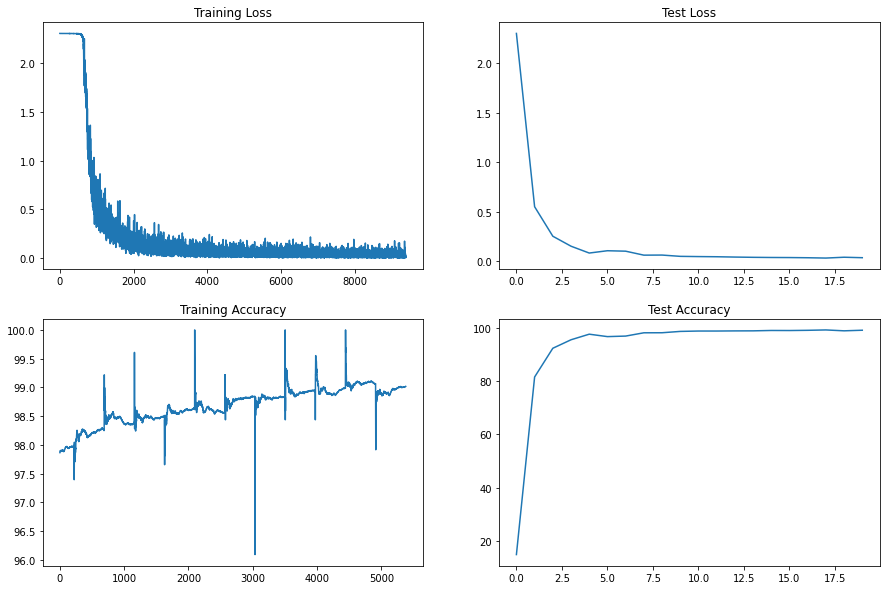

In [39]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracies[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracies)
axs[1, 1].set_title("Test Accuracy")